In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [3]:
sys.path.append('/home/gferro/PhaseAmplification/')

In [4]:
from qat.core.console import display
from qat.qpus import LinAlg

In [5]:
from dataloading_module import  CreateLoadFunctionGate, CreatePG
from kk import get_histogram

In [6]:
#Probability function
def p(x):
    return x*x

def f(x):
    return np.sin(x)
    #return np.cos(x)

# Algoritmo de Amplificación de Amplitud

Tenemos todos los bloques necesarios para implementar la primera parte del algoritmo de amplificación de amplitud:

1. Carga de Proabilidades (Puerta P)
2. Carga de Función a integrar (Puerta R)
3. Operador $\hat{U}_{|\Psi_0\rangle}$
4. Operador $\hat{D}_{0}$
5. Operador Difusor: $\hat{U}_{|\Psi_2\rangle} = \hat{R_{n+1}}\hat{P_{n}}\hat{D}_{0} \hat{P_{n}}^{\dagger} \hat{R_{n+1}}^{\dagger}$

Solo me queda implementar el operador de amplificación de Amplitud $\hat{Q}=\hat{U}_{|\Psi_2\rangle}\hat{U}_{|\Psi_0\rangle}$


In [7]:
#Puertas implementadas y probadas en el Notebook QPA04_PuertasBase
from qat.lang.AQASM import AbstractGate, QRoutine, X, Z
def Reflexion_generator(N):
    """
    Implementa una reflexion en torno al estado |\Phi_0>: I-2|\Phi_0><Phi_0|
    """
    qrout = QRoutine()
    qbits = qrout.new_wires(N)
    qrout.apply(X, qbits[-1])
    qrout.apply(Z, qbits[-1])
    qrout.apply(X, qbits[-1])
    
    return qrout#-Zeroes
UPhi_0 = AbstractGate("UPhi_0", [int])
UPhi_0.set_circuit_generator(Reflexion_generator)

def Reflexion_generator0(N):
    """
    Implementa una reflexion en torno al estado 0: I-2|0><0|
    """
    qrout = QRoutine()
    qbits = qrout.new_wires(N)
    for i in range(N):
        qrout.apply(X, qbits[i])
    #Controlled Z gate by n-1 first qbits
    cZ = 'Z'+ '.ctrl()'*(len(qbits)-1)
    qrout.apply(eval(cZ), qbits[:-1], qbits[-1])
    for i in range(N):
        qrout.apply(X, qbits[i])
    
    return qrout#-Zeroes
D_0 = AbstractGate("D_0", [int])
D_0.set_circuit_generator(Reflexion_generator0)

def LoadDifusorGate(N, ProbabilityArray, FunctionArray):
    from dataloading_module import  CreateLoadFunctionGate, CreatePG
    P_gate = CreatePG(ProbabilityArray)
    R_gate = CreateLoadFunctionGate(FunctionArray)
    def Difusor(nqbits):
        qrout = QRoutine()
        qbits = qrout.new_wires(nqbits)
        qrout.apply(R_gate.dag(), qbits)
        qrout.apply(P_gate.dag(), qbits[:-1])
        qrout.apply(D_0(nqbits), qbits)
        qrout.apply(P_gate, qbits[:-1])
        qrout.apply(R_gate, qbits)
        return qrout
    UPhi_2 = AbstractGate("UPhi_2", [int])
    UPhi_2.set_circuit_generator(Difusor)
    return UPhi_2(N)



### Operador Amplificacion: $\hat{Q}$

Una vez tenemos el los dos operadores $\hat{U}_{|\Psi_0\rangle}$ y $\hat{U}_{|\Psi_2\rangle}$. Podemos montar el Operador de Amplificación: $\hat{Q} = \hat{U}_{|\Psi_2\rangle} \hat{U}_{|\Psi_0\rangle}$

In [8]:
def LoadGroverAmplification(N, ProbabilityArray, FunctionArray):
    difusor = LoadDifusorGate(N, ProbabilityArray, FunctionArray)
    def Grover(N):
        qrout = QRoutine()
        qbits = qrout.new_wires(N)   
        qrout.apply(UPhi_0(N), qbits)
        qrout.apply(difusor, qbits)
        return qrout
    Q = AbstractGate("Q", [int])
    Q.set_circuit_generator(Grover)    
    return Q(N)

## Todo Junto

In [9]:
def DoCircuit(nqbits = 4, K=5, Reflexion = True):
    from qat.lang.AQASM import Program
    nbins = 2**nqbits
    a = 0
    b = 1
    
    #Discretization for the function domain
    centers, probs = get_histogram(p, a, b, nbins)
    #Create Probability loading gate
    P_gate = CreatePG(probs)    

    #Discretizated function to load 
    DiscretizedFunction = f(centers) 
    
    print('La integral es: {}'.format(sum(probs*DiscretizedFunction)))
    #Create Function loading gate    
    R_gate = CreateLoadFunctionGate(DiscretizedFunction)    
    
    #Load Amplification Gates
    Q = LoadGroverAmplification(nqbits+1, probs, DiscretizedFunction)
    difusor = LoadDifusorGate(nqbits+1, probs, DiscretizedFunction)
    
    #Quantum Program
    qprog = Program()
    qbits = qprog.qalloc(nqbits+1)
    qprog.apply(P_gate, qbits[:-1])
    qprog.apply(R_gate, qbits)    
    #qprog.apply(UPhi_0(nqbits+1), qbits) 
    if Reflexion:
        for i in range(K):
            qprog.apply(Q, qbits) 
    #Create the circuit from the program
    circuit = qprog.to_circ()
    linalgqpu = LinAlg()
    """   
    job = circuit.to_job()
    #Import and create the linear algebra simulator
    linalgqpu = LinAlg()
    #Submit the job to the simulator LinAlg and get the results
    result = linalgqpu.submit(job)    
    """

    result = linalgqpu.submit(
        circuit.to_job(qubits = [len(qbits)-1])
    )
     

    QP = []
    States = []
    QA = []
    #Print the results
    for sample in result:
        #print("State %s probability %s amplitude %s" % (sample.state, sample.probability, sample.amplitude))
        QP.append(sample.probability)
        States.append(str(sample.state))
        QA.append(sample.amplitude)
    QP = pd.Series(QP, name='Probability')  
    States = pd.Series(States, name='States')  
    QA = pd.Series(QA, name='Amplitude') 
    pdf = pd.concat([States, QP, QA], axis=1)
    return pdf, circuit

### ¿Cómo funciona esto?

Si ejecutamos la función *DoCircuit* sin ejecutar la amplificación obtendremos simplemente el estado cuántico $|\Psi_{2} \rangle$ en el que se han codificado las distribuciones de probabilidades y la función:

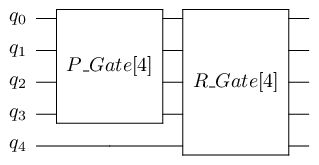

De tal modo que lo que tenemos al final del circuito será:

$$|\Psi_{2}\rangle_{n+1}=\sqrt{a}|\Psi_{1}\rangle+\sqrt{1-a}|\Psi_{0}\rangle$$

$$a=\sum_{x=0}^{2^{n}-1}p(x)f(x)$$

$$|\Psi_{1}\rangle = \frac{1}{\sqrt{a}}\sum_{x=0}^{2^{n}-1}|x\rangle_{n}\otimes\sqrt{p(x)f(x)}|1\rangle$$

$$|\Psi_{0}\rangle = \frac{1}{\sqrt{1-a}}\sum_{x=0}^{2^{n}-1}|x\rangle_{n}\otimes\sqrt{p(x)(1-f(x))}|0\rangle$$

Esto implica que la integral buscada $a=\sum_{x=0}^{2^{n}-1}p(x)f(x)$ será el cuadrado de la amplitud que acompaña al estado $|\Psi_{1}\rangle$.

En la función *DoCircuit* hemos dejado todo implementado para que las salidas sean los dos estados $|\Psi_{1}\rangle$ y $|\Psi_{0}\rangle$

In [13]:
#Solo cargamos datos
nQBITS = 4
pdfNotReflexion, circuitNR = DoCircuit(nQBITS, K=0,Reflexion=False)

La integral es: 0.6693004071633366


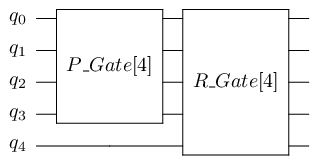

In [14]:
%qatdisplay circuitNR --depth 0

In [15]:
pdfNotReflexion

,States,Probability,Amplitude
0,|0>,0.3307,None
1,|1>,0.6693,None


El resultado de la carga será (para 4 qbits):


<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>States</th>      <th>Probability</th>      <th>Amplitude</th>    </tr>  </thead>  <tbody>    <tr>      <th>0</th>      <td>|0&gt;</td>      <td>0.3307</td>      <td>None</td>    </tr>    <tr>      <th>1</th>      <td>|1&gt;</td>      <td>0.6693</td>      <td>None</td>    </tr>  </tbody></table>

Donde vemos que la probabilidad de obtener $\Psi_{1}$ es 0.6693 que es justo el valor deseado de la integral.

En un ordenador cuántico de verdad tendríamos que preparar todo como se ha explicitado y hace muchas medidas recoger las veces que sale $\Psi_{0}$ y las que sale $\Psi_{1}$ y obtendríamos las integral deseada


In [16]:
Prob_0 = pdfNotReflexion['Probability'][1]
Theta0 = np.arcsin(np.sqrt(Prob_0))
print('Theta0: {}'.format(Theta0))

Theta0: 0.9581129008449892


In [17]:
#una aplicación de Q sería rotar 2theta todo el sistema: rotación final de 3theta
print('3*Theta0: {}'.format(3*Theta0))
print('sin(3*Theta0): {}'.format(np.sin(3*Theta0)))
print('sin^2(3*Theta0): {}'.format(np.sin(3*Theta0)**2))

3*Theta0: 2.874338702534968
sin(3*Theta0): 0.26408387228011587
sin^2(3*Theta0): 0.06974029159846055


Realizar una aplicacion del algoritmo de amplificación es equivalente a hacer una rotación en torno al eje Y de $2\theta$ sobre el estado $|\Psi_2\rangle$ por lo que el angulo final es de $3\theta$:

$$\hat{Q}|\Psi_2\rangle = cos(3\theta)|\Psi_0\rangle + \sin(3\theta)|\Psi_1\rangle$$

Para comprobar que los hemos hecho bien probemos los siguientes números:

Cuando no aplicamos el operador $\hat{Q}$ el estado $|\Psi_2\rangle$ está definido por un una ángulo 
$$\theta_0 = 0.958112900844989$$ 
Si ahora a ese ángulo le hacemos 
$$3\theta_0= 2.874338702534967$$. 
$$\sin(3\theta_0) = 0.2640838722801167$$

Cuando hacemos $\hat{Q}|\Psi_2\rangle$ se puede comprobar que la probabilidad de obtener el estado $|\Psi_1\rangle$ es de $\sin^{2}(3\theta_0)$. Así pues tras hacer $\hat{Q}|\Psi_2\rangle$ se debería verificar que:

$$P_{|\Psi_1\rangle}(\hat{Q}|\Psi_2\rangle) = \sin^{2}(3\theta_0) = 0.069740291598461$$

Veamos si esto es lo que sale:

La integral es: 0.6693004071633366


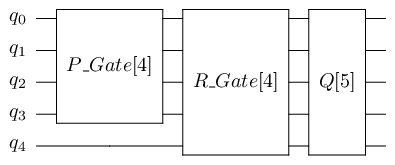

Probabilidad de medir \Psi_1 despues de hacer Q\Psi_2: 0.06974029159846043


In [18]:
K=1
pdfReflexion, circuitR = DoCircuit(nQBITS, K=K)
%qatdisplay circuitR --depth 0
Prob = pdfReflexion['Probability'][1]
print('Probabilidad de medir \Psi_1 despues de hacer Q\Psi_2: {}'.format(Prob))

In [19]:
#Para cualquier K

K = 2
theta = (2*K+1)*Theta0
print('(2*k+1)*Theta0 (k={}): {}'.format(K, theta))
print('sin((2*k+1)*Theta0) (k={}): {}'.format(K,np.sin(theta)))
print('sin^2((2*k+1)*Theta0:) (k={}): {}'.format(K, np.sin(theta)**2))

(2*k+1)*Theta0 (k=2): 4.790564504224946
sin((2*k+1)*Theta0) (k=2): -0.9969458496426231
sin^2((2*k+1)*Theta0:) (k=2): 0.9939010271196517


2
La integral es: 0.6693004071633366


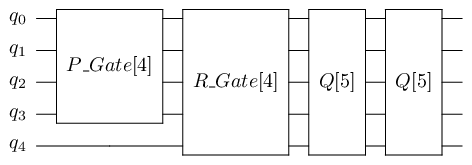

,States,Probability,Amplitude
0,|0>,0.006099,None
1,|1>,0.993901,None


In [20]:
print(K)
pdfReflexion, circuitR = DoCircuit(nQBITS, K = K)
%qatdisplay circuitR --depth 0
pdfReflexion

La implementación del Operador de Amplificación de Amplitud $\hat{Q}$ parece que está bien implementada

In [19]:
Prob = pdfReflexion['Probability'][1]
Theta = np.arcsin(np.sqrt(Prob))
print('Theta: {}'.format(Theta))

Theta: 0.2672539510548252


In [33]:
np.sin(np.arcsin(np.sqrt(0.993901)))

0.9969458360412565

In [32]:
np.sin(5*Theta0)

-0.9969458496426231

In [ ]:
sum(pdfNotReflexion[pdfNotReflexion['States'].str.extract(r'(\d)>')[0]=='1'][''])

In [ ]:
sum(pdfReflexion[pdfReflexion['States'].str.extract(r'(\d)>')[0]=='1']['Amplitude'])

In [ ]:
pdfReflexion[pdfReflexion['States'].str.extract(r'(\d)>')[0]=='1']

In [ ]:
pdfNotReflexion[pdfNotReflexion['States'].str.extract(r'(\d)>')[0]=='1']